# Routing

## Problem statement

## PuLP


In [1]:
import pulp
import pandas as pd
from collections import defaultdict
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def read_json(filename):
    with open(filename) as file:
        json_file = json.load(file)
    return json_file

In [3]:
folder = 'data/'
file = '5x5'
extension = '.json'
filename = file + extension
json_file = read_json(folder + filename)

dim = json_file['dimension']
pin_location = json_file['pins']
nPoints = len(pin_location)
P = range(nPoints)
D = range(dim)

pulp_instance = pulp.LpProblem("Routing", pulp.LpMinimize)

# Variables and Objective Function

In [4]:
boards = pulp.LpVariable.dicts('boards', ((p, d1, d2) for p in P for d1 in D for d2 in D)
                               , cat='Integer', lowBound=0, upBound=1)

main_board = pulp.LpVariable.dicts('main_board', ((d1, d2) for d1 in D for d2 in D)
                                   , cat='Integer', lowBound=0, upBound=1)

pulp_instance += pulp.lpSum([main_board[d,d2] for d in D for d2 in D])

# Constraints

In [5]:
## CONSTRAINT 1: EACH PAIR OF POINTS BELONGS TO A SINGLE BOARD
for p in P:
    pulp_instance += boards[p, pin_location[p][0][0], pin_location[p][0][1]] == 1
    pulp_instance += boards[p, pin_location[p][1][0], pin_location[p][1][1]] == 1

In [6]:
## CONSTRAINT 2: THE MARKED POSITIONS HAVE TO BE DIFFERENT
## AMONG ALL THE PANELS (AVOID COLLISIONS).
for p in P:
    for p2 in P:
        if p != p2:
            for d in D:
                for d2 in D:
                    pulp_instance += (1 - boards[p, d, d2]) >= boards[p2, d, d2];

In [7]:
## CONSTRAINT 3: ALL MARKED POSITIONS IN INDIVIDUAL BOARDS
## HAVE TO APPEAR IN THE GENERAL BOARD
for p in P:
    for d in D:
        for d2 in D:
            pulp_instance += boards[p, d, d2] <= main_board[d, d2];

In [8]:
def is_pin(p, location):
    return location in pin_location[p]

In [9]:
def check_left(p, d, d2):
    if d2 > 0:
        return (boards[p, d, d2 - 1], 1)
    else:
        return (0, 0)
    
def check_right(p, d, d2):
    if d2 < dim - 1:
        return (boards[p, d, d2 + 1], 1)
    else:
        return (0, 0)
        
def check_above(p, d, d2):
    if d > 0:
        return (boards[p, d - 1, d2], 1)
    else:
        return (0, 0)
            
def check_below(p, d, d2):
    if d < dim - 1:
        return (boards[p, d + 1, d2], 1)
    else:
        return (0,0)

def check_neighbors(p, d, d2):
    neighborhood = [check_left(p, d, d2), check_right(p, d, d2), \
        check_above(p, d, d2), check_below(p, d, d2)]
    
    return (sum([i[0] for i in neighborhood]), # Sum of neighbors
            sum([i[1] for i in neighborhood])) # Upper bound
            

In [10]:
## CONSTRAINT 4: NEIGHBOURHOOD OF PINS AND NO PIN VALUES:
## - PINS: MUST HAVE EXACTLY ONE NEIGHBOUR
## - NO PINS: THERE ARE TWO CASES:
##   + WHERE WIRES ARE PASSING: MUST HAVE EXACTLY TWO NEIGHBOURS
##   + WHERE NOT WIRES ARE PASSING: DEPENDS ON THE CELL OF THE NO PIN.
for p in P:
    for d in D:
        for d2 in D:
            num_neigh, upper_bound = check_neighbors(p, d, d2)
            lower_bound = -2
            if is_pin(p, [d, d2]):
                pulp_instance += num_neigh == 1
            else:
                ## board[p,d,d2] == 1 --> num_neigh == 2
                
                ## board[p,d,d2] == 1 --> num_neigh <= 2
                pulp_instance += num_neigh - 2 <= upper_bound*(1 - boards[p,d,d2])
                
                ## board[p,d,d2] == 1 --> num_neigh >= 2
                pulp_instance += num_neigh - 2 >= lower_bound*(1 - boards[p,d,d2])

# Solution

In [11]:
solution = pulp_instance.solve()
print(pulp.LpStatus[solution])

Optimal


In [12]:
def get_triplet(string):
    str_l = string.split(',_')
    return [int(str_l[0][1]), int(str_l[1]), int(str_l[2][0])]

In [13]:
def convert_to_dict():
    dictionary = defaultdict(list)
    points_no_clean = [boards[i].name.split('s_')[1] for i in boards if boards[i].value() != 0]
    for i in points_no_clean:
        triplet = get_triplet(i)
        dictionary[triplet.pop(0)] += [triplet]
    return dictionary

In [14]:
def save_board():
    points = convert_to_dict()
    with open(folder + 'results_' + filename, 'w') as fp:
        json.dump(points, fp, indent=4)
    return points

In [15]:
m = save_board()

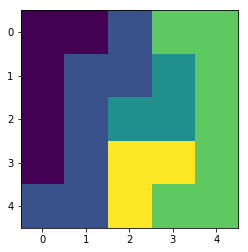

In [16]:
board = np.zeros(shape=(dim, dim))

for color in m:
    for point in m[color]:
        board[point[0], point[1]] = int(color)

plt.imshow(board,  cmap='viridis')
plt.savefig(folder + file + '_plot.pdf', format='pdf')